# Downstream: DGEA and GSEA

Differential gene expression (DGE) analysis is a crucial tool for identifying genes that are significantly over- or underexpressed between different conditions (e.g., healthy vs. disease) within specific cell types. While many tools exist for DGE analysis, recent studies suggest that pseudobulk methods (which aggregate cell-type-specific expression values per individual) perform particularly well for single-cell data, helping to avoid issues like pseudoreplication and inflated false discovery rates. In this tutorial, we'll show how to perform both, primarily using the packages `decoupleR` and `pybiomart` for gene symbol conversion. If you haven't yet installed it, you can do so with

```
pip install decoupler pybiomart
```

In [3]:
#! pip install decoupler pybiomart

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt

# for differential expression analysis
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import adjustText

sc.settings.njobs = 1

## Understanding Pseudobulk Analysis

When working with single-cell data across multiple conditions, performing differential expression at the single-cell level can lead to inflated p-values because each cell is treated as an independent sample. However, cells from the same sample are not truly independent since they share the same environment. Additionally, uneven cell numbers between samples can bias results.

The pseudobulk approach addresses these issues by:
1. Aggregating cells from the same sample and cell type
2. Working with raw counts rather than normalized data
3. Requiring multiple biological replicates per condition
4. Accounting for sample-level variation

## Generate Pseudobulks

We'll now create pseudobulk profiles by summing counts across cells from the same sample and cell type. This helps recover lowly expressed genes that might be affected by dropout in single-cell analysis and provides a more robust foundation for differential expression testing.

In [2]:
adata_raw = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = [
    "Sample Characteristic[sex]",
    "Sample Characteristic[individual]",
    "Sample Characteristic[disease]",
    "Factor Value[inferred cell type - ontology labels]",
]
adata_raw.obs = adata_raw.obs[columns]
adata_raw.obs.columns = ["sex", "individual", "disease", "cell_type"]
adata_raw

adata_raw

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

In [3]:
adata_raw.to_df().head()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,...,ENSG00000289568,ENSG00000289604,ENSG00000289685,ENSG00000289690,ENSG00000289694,ENSG00000289695,ENSG00000289697,ENSG00000289700,ENSG00000289701,ENSG00000289716
SAMEA6979313-AAACCCAAGACTCAAA,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMEA6979313-AAAGAACCACCTGCTT,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMEA6979313-AAAGGATGTCCCTCAT,0.0,1.082781,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SAMEA6979313-AAAGGGTGTCCCTCAT,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
SAMEA6979313-AAAGGTTGTCCCTCAT,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

### Aligning gene identifiers
One common challenge in bioinformatics is dealing with different gene identifier systems. We'll use ENSEBML IDs for the following steps since these are usually more precise than gene symbols.

In [4]:
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "external_gene_name"], use_cache=False
).set_index("ensembl_gene_id")
annot.head()

,external_gene_name
ensembl_gene_id,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1


In [7]:
# Filter genes not in annotation
adata = adata_raw[:, adata_raw.var.index.intersection(annot.index.values)]

# Assign gene symbols
adata.var["gene_symbol"] = [
    annot.loc[ensembl_id, "external_gene_name"] for ensembl_id in adata.var.index
]
adata.var = (
    adata.var.reset_index()
    .rename(columns={"index": "ensembl_gene_id"})
    .set_index("gene_symbol")
)

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicate genes
adata.var_names_make_unique()

adata

/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_37174/752738889.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_symbol"] = [
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6807 × 20445
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

In [8]:
# let's remove cells without an annotated celltype for easier downstream analysis
adata = adata[~adata.obs["cell_type"].isnull()]

We will need the raw counts for subsequent pseudo-bulk analysis, so let's save them in another `AnnData` layer.

In [9]:
adata.X = np.round(adata.X)
adata.layers["counts"] = adata.X.copy()

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X.copy()

/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_37174/775170324.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = np.round(adata.X)
/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_37174/775170324.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [10]:
# Check that elements are integers by comparing rounded values to originals
counts_matrix = adata.layers["counts"][:1, :10][adata.layers["counts"][:1, :10]>0]
X_matrix = adata.X[:1, :10][adata.X[:1, :10]>0]
assert np.round(counts_matrix) == counts_matrix
assert not np.round(X_matrix) == X_matrix

/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)
/Users/francesca.drummer/miniconda3/envs/workshop_2025/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


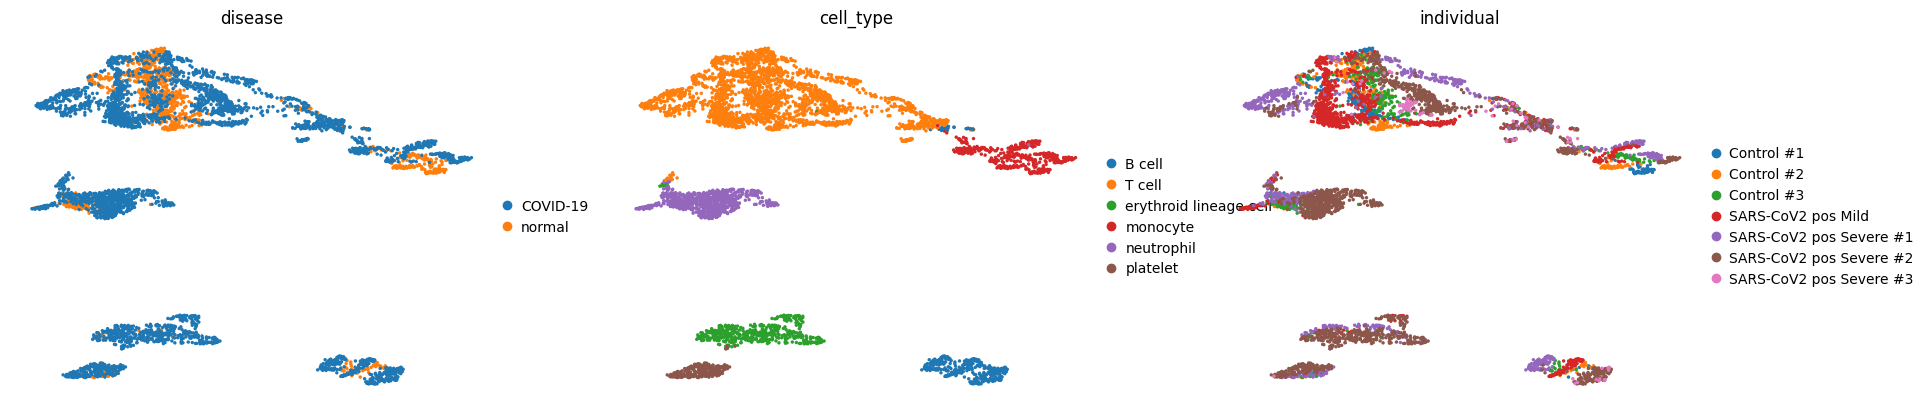

In [11]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=2000, batch_key="individual"
)

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=["disease", "cell_type", "individual"], frameon=False)

We can see that we have fairly good mixing of disease conditions (COVID-19/normal) and individuals in our data while the cell types are mostly separated.

### Assess the quality of our pseudo-bulks
When generating pseudobulk profiles, we need to ensure that each aggregated sample has sufficient data for reliable analysis. Samples with too few cells or low total counts may introduce noise and bias into downstream analyses. While the specific thresholds depend on the dataset, requiring at least 10 cells and 1000 total counts per sample helps maintain statistical power while filtering out potentially unreliable measurements.

In [12]:
pdata = dc.pp.pseudobulk(
    adata,
    sample_col="individual",  # so we have multiple samples
    groups_col="cell_type",  # defines contrasts
    layer="counts",  # use normalized counts
    mode="sum",  # sum up counts for each group
)

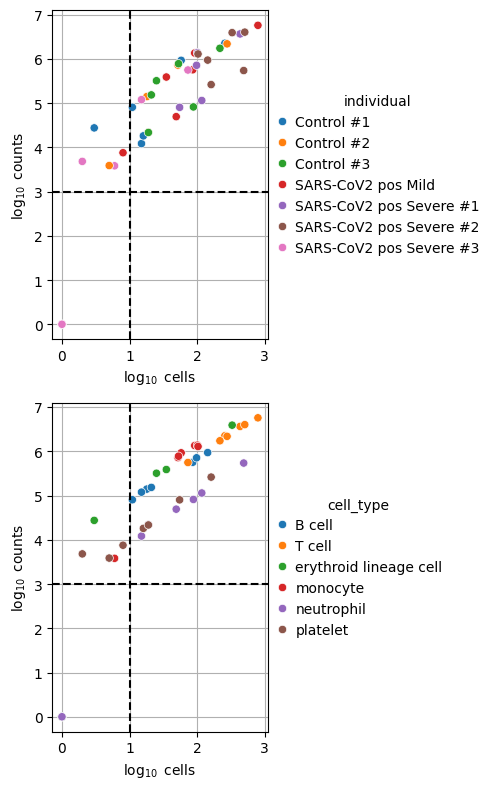

In [13]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["individual", "cell_type"],
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

We'll filter out celltype-individual pseudo-bulks that don't contain at least 10 cells and 1000 total counts.

In [14]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

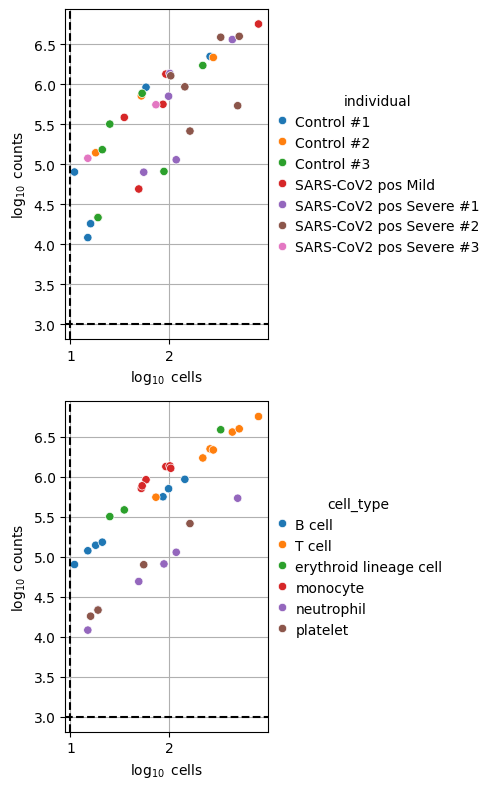

In [15]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["individual", "cell_type"],
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

We can see that we now end up with 34 observations which represent the filtered `individual_celltype` combinations.

In [16]:
pdata

AnnData object with n_obs × n_vars = 34 × 20445
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    layers: 'psbulk_props'

In [17]:
pdata.to_df().head(8)

gene_symbol,STX16-NPEPL1,ZBTB5,TRDV2,TNFSF13B,RBM41,CELA1,TUG1,POLR1H-1,DPF1,TLR8,...,NUDCP2,POLR3G,MNAT1,DNMT3B,MPPED2,UQCC2,LRRC9,CHD3,HACD4,RTEL1P1
Control #1_B cell,0.0,1.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,2.0,0.0,5.0,1.0,0.0
Control #2_B cell,3.0,2.0,0.0,1.0,8.0,0.0,9.0,3.0,0.0,0.0,...,0.0,0.0,5.0,0.0,14.0,2.0,0.0,0.0,7.0,0.0
Control #3_B cell,0.0,0.0,0.0,0.0,8.0,0.0,6.0,2.0,0.0,0.0,...,0.0,0.0,7.0,0.0,7.0,1.0,0.0,4.0,2.0,0.0
SARS-CoV2 pos Mild_B cell,0.0,2.0,0.0,4.0,70.0,0.0,24.0,10.0,0.0,0.0,...,0.0,0.0,24.0,0.0,11.0,15.0,0.0,19.0,11.0,0.0
SARS-CoV2 pos Severe #1_B cell,0.0,8.0,0.0,3.0,45.0,0.0,58.0,0.0,0.0,0.0,...,0.0,1.0,7.0,0.0,28.0,4.0,0.0,39.0,12.0,0.0
SARS-CoV2 pos Severe #2_B cell,3.0,10.0,0.0,2.0,43.0,0.0,57.0,0.0,1.0,0.0,...,0.0,0.0,19.0,0.0,20.0,14.0,0.0,32.0,17.0,0.0
SARS-CoV2 pos Severe #3_B cell,0.0,0.0,0.0,0.0,18.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,2.0,0.0,2.0,3.0,1.0
Control #1_T cell,16.0,19.0,0.0,12.0,132.0,20.0,112.0,0.0,0.0,1.0,...,1.0,8.0,58.0,0.0,80.0,49.0,0.0,222.0,119.0,0.0


In [18]:
# save counts and norm_counts to not overwrite the "counts" with normalized counts later on
pdata.layers["counts"] = pdata.X.copy()
pdata.layers["norm_counts"] = pdata.X.copy()

In [19]:
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

In [20]:
# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4, layer="norm_counts")
sc.pp.log1p(pdata, layer="norm_counts")
sc.pp.scale(pdata, max_value=10, layer="norm_counts")
sc.tl.pca(pdata, layer="norm_counts")

In [21]:
pdata.X = pdata.layers["norm_counts"]

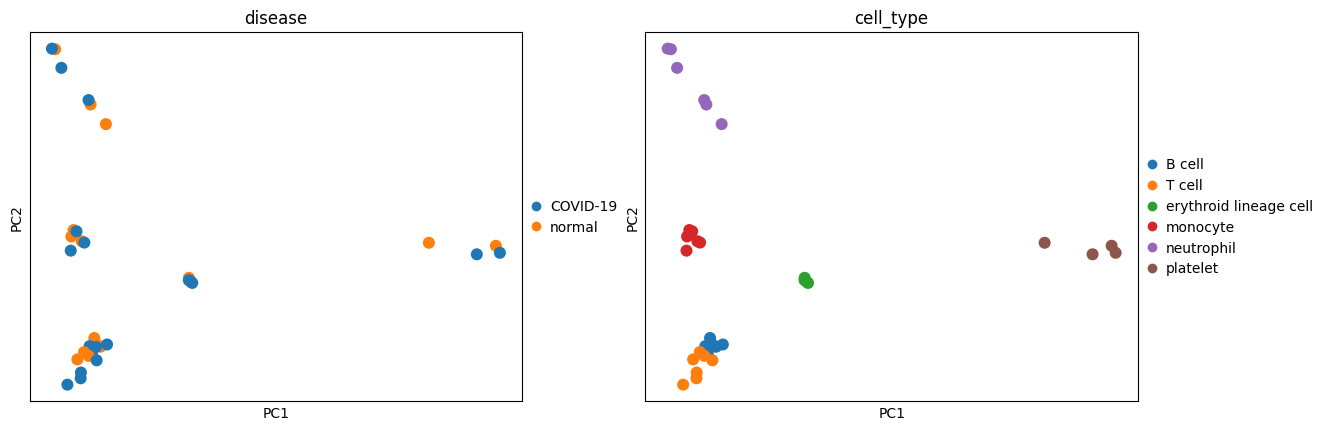

In [22]:
sc.pl.pca(pdata, color=["disease", "cell_type"], size=300)

We see in the PCA that our data seems to cluster well by celltype whereas conditions are mixed. In the plot below we see that PC1 and PC2 explain the majority of the variance which explains why the above plots are separated so well.

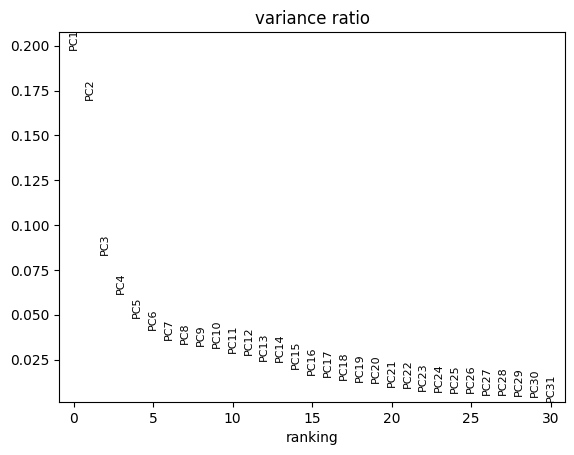

In [23]:
sc.pl.pca_variance_ratio(pdata)

### Denoising the pseudo-bulks
After filtering low-quality samples, we need to ensure that the genes we analyze are reliably expressed. Since different cell types express distinct sets of genes, we perform this filtering separately for each cell type. 

In the next steps, we'll focus on T cells.

In [24]:
tcells = pdata[pdata.obs["cell_type"] == "T cell"].copy()
tcells.X = tcells.layers["counts"]

We expect a bimodal distribution in these genes with one cluster of genes being expressed very little and only by very few samples. We will adjust the `min_count` and `min_total_count` parameters to filter these out.

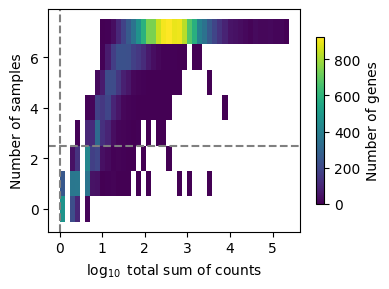

In [25]:
dc.pl.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=1,
    min_total_count=1,
    large_n=10,
    min_prop=0.7,
)

Once we've found sufficiently good values, we'll use these to subset the genes in the T cell `AnnData` object. 

In [45]:
#genes = dc.filter_by_expr(tcells, group="disease", min_count=10, min_total_count=15)
dc.pp.filter_by_expr(
    adata=tcells,
    group="disease",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.7,
)

In [46]:
tcells

AnnData object with n_obs × n_vars = 7 × 10587
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca', 'disease_colors', 'cell_type_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts', 'norm_counts', 'X'

## Differential expression analysis of the pseudo-bulks using `pydeseq2`
In this dataset, a natural contrast to explore is how the gene expression of T cells differes between healthy patients and patienst suffering from COVID-19. To do so, we'll use PyDESeq2, a Python implementation of the popular R packages.

More details can be found in the [PyDESeq2 documentation](https://pydeseq2.readthedocs.io/en/latest/)

In [80]:
tcells.X = tcells.layers["counts"]

In [99]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    adata=tcells,
    design_factors="disease",
    ref_level=["normal", "COVID-19"],
    refit_cooks=True,
    inference=inference,
)

/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_23570/1872437166.py:3: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/var/folders/sr/x0w569jx2ts65c68fz7_4c300000gn/T/ipykernel_23570/1872437166.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [100]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.87 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.80 seconds.

Fitting LFCs...
... done in 0.46 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [101]:
stat_res = DeseqStats(
    dds,
    contrast=["disease", "COVID-19", "normal"],
    inference=inference,
)

In [102]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                              
DLST           44.670793        0.216321  0.307929  0.702502  0.482366   
FKBP15         27.712993        0.253260  0.408526  0.619937  0.535299   
RSKR           85.828478       -0.226385  0.283646 -0.798126  0.424797   
NDUFAF7        34.614614       -0.166532  0.359589 -0.463118  0.643280   
ZSCAN32         7.872757       -0.037297  0.657359 -0.056737  0.954755   
...                  ...             ...       ...       ...       ...   
FBLIM1        872.615666       -0.132914  0.232204 -0.572404  0.567049   
nan-877      3968.352124       -0.288489  0.184246 -1.565785  0.117399   
CC2D2A        136.352212       -0.486351  0.227556 -2.137281  0.032575   
CNKSR2         13.286579       -0.605080  0.501585 -1.206337  0.227688   
SPDYA           5.817614       -0.460428  0.792

... done in 0.35 seconds.



In [103]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
DLST,44.670793,0.216321,0.307929,0.702502,0.482366,0.874675
FKBP15,27.712993,0.253260,0.408526,0.619937,0.535299,0.896234
RSKR,85.828478,-0.226385,0.283646,-0.798126,0.424797,0.852271
NDUFAF7,34.614614,-0.166532,0.359589,-0.463118,0.643280,0.926449
ZSCAN32,7.872757,-0.037297,0.657359,-0.056737,0.954755,0.995261
...,...,...,...,...,...,...
FBLIM1,872.615666,-0.132914,0.232204,-0.572404,0.567049,0.905743
nan-877,3968.352124,-0.288489,0.184246,-1.565785,0.117399,0.603727
CC2D2A,136.352212,-0.486351,0.227556,-2.137281,0.032575,0.360010


### Visual inspection of differentially expressed genes
Volcano plots visualize differential expression results by plotting statistical significance (-log10 p-value) against effect size (log2 fold change). They help quickly identify genes that show both significant and substantial expression changes between conditions, making them a valuable tool for prioritizing genes for further investigation.

Typically, one adds visual guiding lines at 1.3 for the y-axis (-log10(0.05)) and +/- 1 log2(2) foldchange for the x-axis. 

#### Why the adjusted p-value?
When performing differential expression analysis across thousands of genes, we use adjusted p-values (typically Benjamini-Hochberg correction) to control for multiple testing. This is crucial because testing many genes simultaneously increases the chance of false positives - if we used raw p-values and tested 10,000 genes at p < 0.05, we'd expect about 500 false positives by chance alone. The adjusted p-value (or FDR - False Discovery Rate) helps control this problem by adjusting the significance threshold based on the number of tests performed, giving us more confidence that our findings represent true biological differences rather than statistical artifacts.

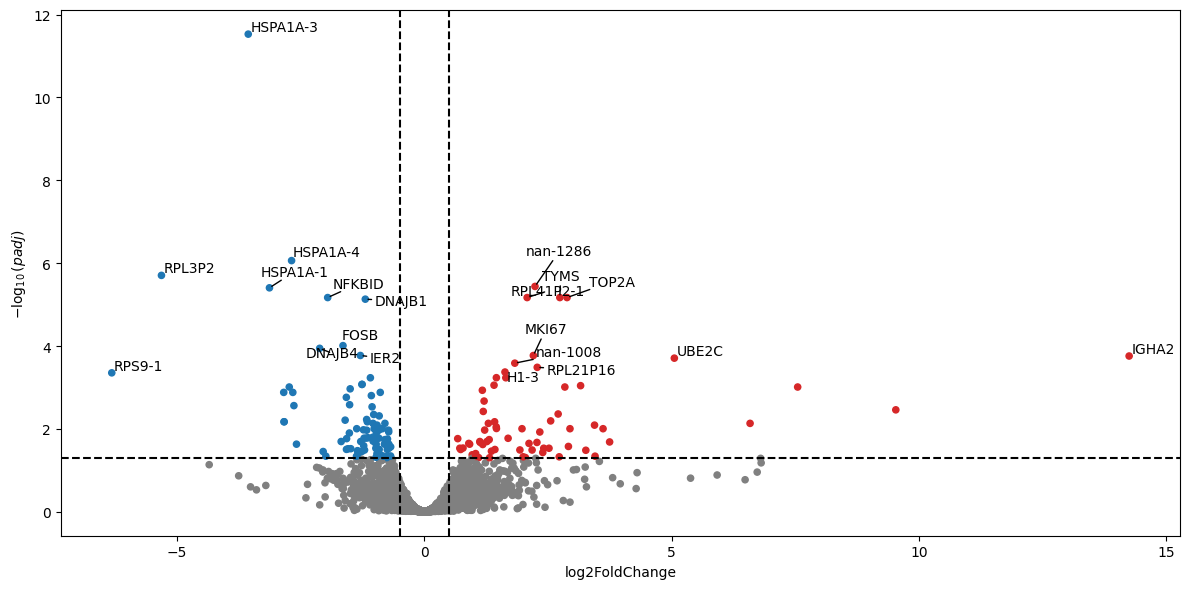

In [104]:
dc.pl.volcano(results_df, x="log2FoldChange", y="padj", top=20, figsize=(12, 6))

## Enrichment with Over Representation Analysis (ORA)

Once we have identified differentially expressed genes, we can interpret their biological significance through enrichment analysis. This helps us understand which pathways or biological processes are altered between conditions. We'll use:

1. Over-Representation Analysis (ORA): Tests whether genes in a pathway appear more frequently than expected by chance in our set of differential genes
2. MSigDB gene sets: A comprehensive collection of annotated gene sets for various biological processes
3. Visualization of enrichment results to identify key pathways

This analysis helps translate our gene-level findings into biological insights about pathway regulation and cellular processes.

In [144]:
collection = "progeny"

if collection == "hallmark":
    hallmark = dc.op.hallmark(organism="human")
    print(hallmark.head())
elif collection == "progeny":
    progeny = dc.op.progeny(organism="human")
    print(progeny.head())

     source   target     weight          padj
0  Androgen  TMPRSS2  11.490631  2.384806e-47
1  Androgen   NKX3-1  10.622551  2.205102e-44
2  Androgen   MBOAT2  10.472733  4.632376e-44
3  Androgen     KLK2  10.176186  1.944410e-40
4  Androgen     SARG  11.386852  2.790210e-40


In [116]:
data = results_df[["stat"]].T.rename(index={"stat": "disease.vs.normal"})
data

gene_symbol,DLST,FKBP15,RSKR,NDUFAF7,ZSCAN32,OSBPL11,CYBB,ATP6V1D,YJU2,SSBP1,...,DEPDC4,TMEM160,RPL21P51,SMG1P1,GTF2H3,FBLIM1,nan-877,CC2D2A,CNKSR2,SPDYA
disease.vs.normal,0.702502,0.619937,-0.798126,-0.463118,-0.056737,0.832701,-0.962503,-2.222381,0.646662,2.158275,...,-1.460901,0.968241,0.371526,0.244249,1.43189,-0.572404,-1.565785,-2.137281,-1.206337,-0.58079


In [134]:
# Run
tf_acts, tf_padj = dc.mt.ulm(data=data, net=progeny)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

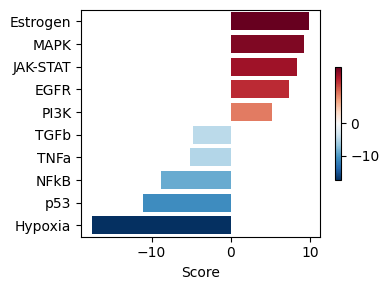

In [135]:
dc.pl.barplot(data=tf_acts, name="disease.vs.normal", figsize=(4, 3))



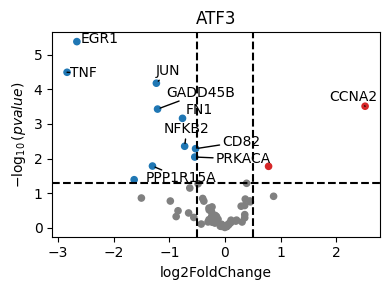

In [136]:
dc.pl.volcano(
    data=results_df,
    x="log2FoldChange",
    y="pvalue",
    net=collectri,
    name="ATF3",
    top=10,
)

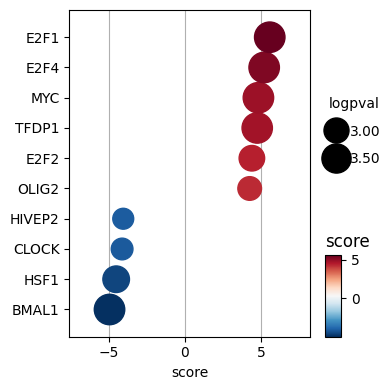

In [143]:
if collection == "progeny":
    df = pw_acts.melt(value_name="score").merge(
    pw_padj.melt(value_name="pvalue")
    .assign(logpval=lambda x: x["pvalue"].clip(2.22e-4, 1))
    .assign(logpval=lambda x: -np.log10(x["logpval"]))
    )
    dc.pl.dotplot(df=df, x="score", y="variable", s="logpval", c="score", scale=1, figsize=(4, 4))
if collection == "hallmark":
    df = pw_acts.melt(value_name="score").merge(
        pw_padj.melt(value_name="pvalue")
        .assign(padj=lambda x: x["pvalue"].clip(2.22e-16, 1))
        .assign(padj=lambda x: np.log10(x["pvalue"]))
    )
    dc.pl.dotplot(df=df, x="score", y="variable", s="padj", c="score", scale=0.25, figsize=(6, 3))

